# Admixture complex calibration

## Setup

In [1]:
library(tidyverse)
library(wesanderson)
library(gridExtra)
library(ggforce)
library(qqplotr)
library(svglite)
library(GGally)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘qqplotr’


The following objects are masked from ‘package:ggplot2’:

    stat_qq_line, StatQqLine


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



In [2]:
pal <- wes_palettes$"BottleRocket2"
colors <- pal[1:4]
popcolors <- c('#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33')

### Useful functions

In [3]:
wrap_by <- function(...) {
  facet_wrap(vars(...), labeller = label_both)
}
plotFrequencies <- function(df, scoef, mcoef){
    df %>% 
        filter(s==scoef&m==mcoef) %>%
        ggplot(aes(x=generation, y=freq, color = pop) ) +
        geom_point(size=0.1, alpha = 0.01 ) +
        facet_wrap(~pop, ncol=1, strip.position="right") +
        ylim(c(0,1)) +
        theme_light() +
        theme(legend.position = "none") +
        labs(subtitle = paste0("m=",mcoef)) +
        scale_color_manual(values=popcolors)
    
}


### Read data

In [4]:
hapflk <- read_delim("complex.tab.gz", delim = " ")


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  chr = col_double(),
  pos = col_double(),
  flk = col_double(),
  replicate = col_double(),
  covariance = col_character(),
  hapflk = col_double(),
  s = col_double(),
  m = col_double()
)




In [5]:
hapflk$s <- factor(hapflk$s)
hapflk$m <- factor(hapflk$m)

In [6]:
frequencies <- read_delim("frequencies_complex.tsv.gz", delim = " ") %>% filter(pop!="index")
frequencies$s <- factor(frequencies$s)
frequencies$m <- factor(frequencies$m)


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  generation = col_double(),
  pop = col_character(),
  freq = col_double(),
  s = col_double(),
  m = col_double(),
  rep = col_double()
)




In [7]:
K <- 10
n_pop <- 4

In [8]:
flk_df <- n_pop-1

In [9]:
hapflk_df <- (n_pop -1) *(K -1)

## Data summaries

In [10]:
max_gen <- frequencies %>% pull(generation) %>% max()
max_gen

[1] 5900

Hay algunas simulaciones que perdieron m2 en p4, asi que filtro sólo aquellas que no se perdieron.

In [11]:
out_reps <- frequencies %>% 
            filter(generation==max_gen) %>%
            filter(s==0.1&pop=="p4"&freq < 0.5) %>% 
            select(rep,s,m) %>% distinct()

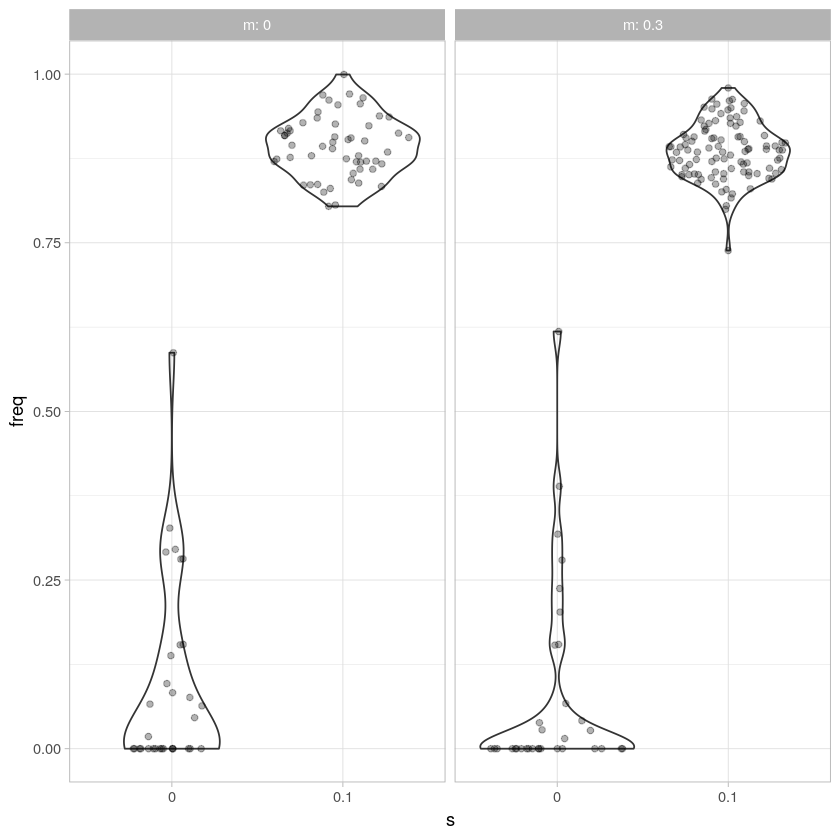

In [12]:
anti_join(frequencies, out_reps, by=c("rep","s","m")) %>%
        filter(generation==max_gen) %>%
        filter(pop=="p4") %>%
        ggplot(aes(x=s, y=freq)) +
        geom_violin(fill=NA) +
        geom_sina(alpha= 0.3) +
        ylim(c(0,1)) +
        theme_light() +
        wrap_by(m)

In [13]:
hapflk <- anti_join(frequencies, out_reps, by=c("rep","s","m")) %>% 
            select(rep,s,m) %>%
            distinct() %>%
            rename(replicate="rep") %>%
            left_join(.,hapflk)

Joining, by = c("replicate", "s", "m")



In [14]:
frequencies <- anti_join(frequencies, out_reps, by=c("rep","s","m")) %>% 
                select(rep,s,m) %>%
                distinct() %>%
                left_join(., frequencies)

Joining, by = c("rep", "s", "m")



Vamos a ver como cambio el numero de replicas usadas

In [15]:
reps <- hapflk %>%
        dplyr::select(replicate, s,m) %>%
        distinct() %>%
        mutate(replicate=factor(replicate)) %>%
        group_by(s,m) %>%
        summarise(analysed_simulations=n())

`summarise()` has grouped output by 's'. You can override using the `.groups` argument.



In [16]:
reps

s   m   analysed_simulations
1 0   0   100                 
2 0   0.3 100                 
3 0.1 0    58                 
4 0.1 0.3 100

In [17]:
write_delim(reps,"calibration-reps.tsv",delim = "\t")

`summarise()` has grouped output by 'replicate', 's'. You can override using the `.groups` argument.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



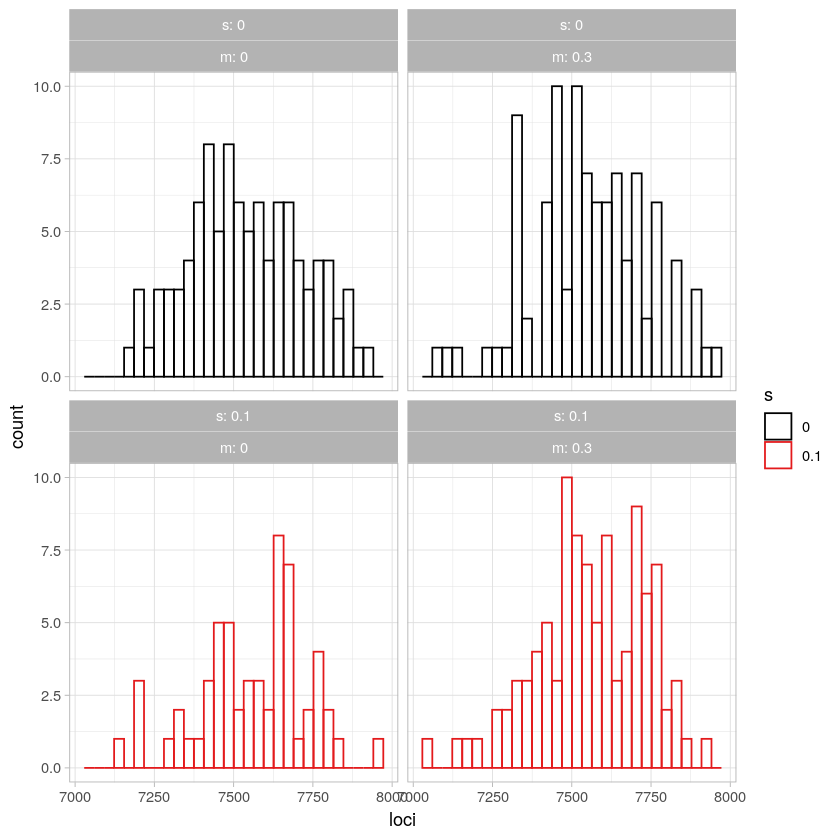

In [18]:
hapflk %>%
        dplyr::select(pos, replicate,s,m)%>%
        distinct() %>%
        group_by(replicate,s,m) %>%
        summarise(loci=n()) %>%
        ggplot() +
        geom_histogram(aes(x=loci, color = s), fill= NA) +
        wrap_by(s,m) +
        theme_light() +
        scale_color_manual(values=c( "black", "#e31a1c"))

La poblacion que esta bajo seleccion es p4, en el escenario con m=0, la mutacion adaptativa probabemente se perdió antes del sweep.

Warning message:
“Removed 68849 rows containing missing values (geom_point).”
Warning message:
“Removed 99836 rows containing missing values (geom_point).”


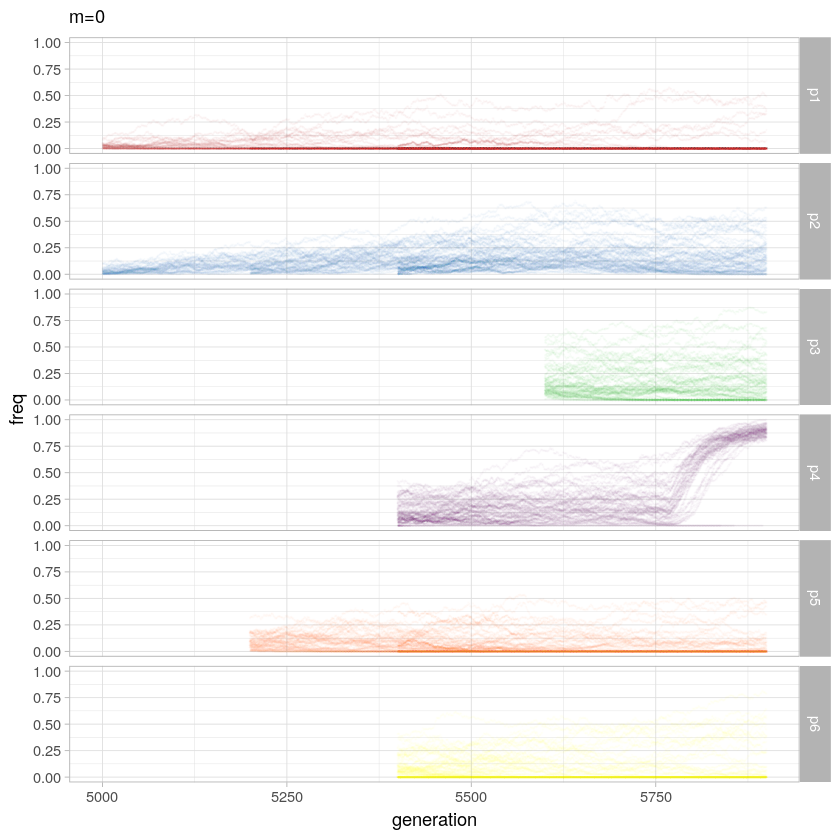

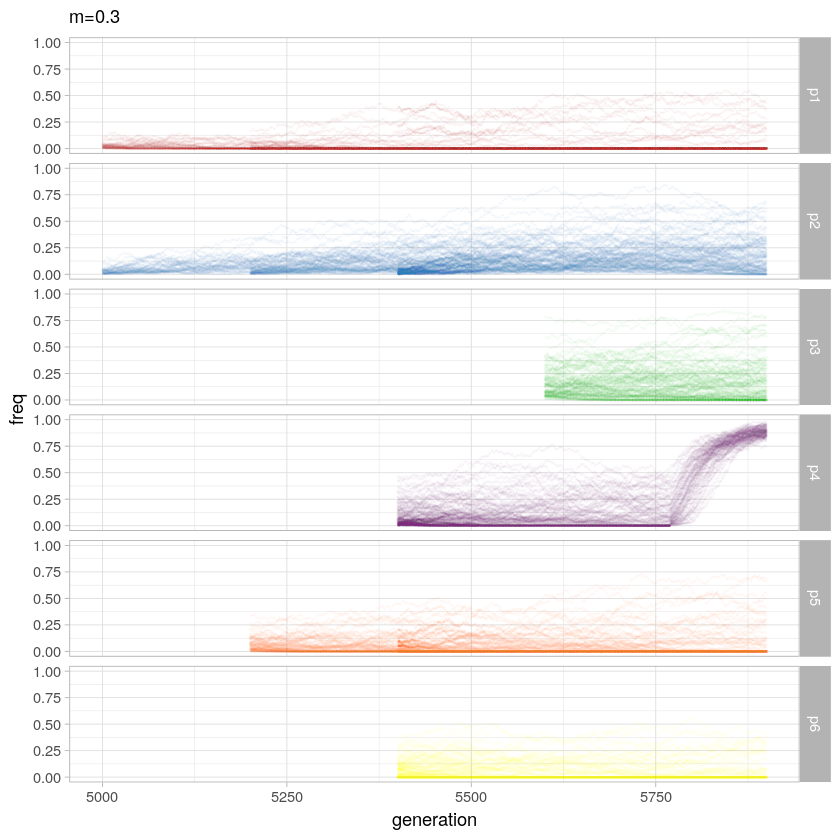

In [19]:
plotFrequencies(frequencies,0.1,0)
plotFrequencies(frequencies,0.1,0.3)


# Statistics QC

## Statistics distribution

View distribution of FLK values for no admixture scenario (m=0) and for admixture scenario (m=0.3).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 50713 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 50713 rows containing non-finite values (stat_density).”


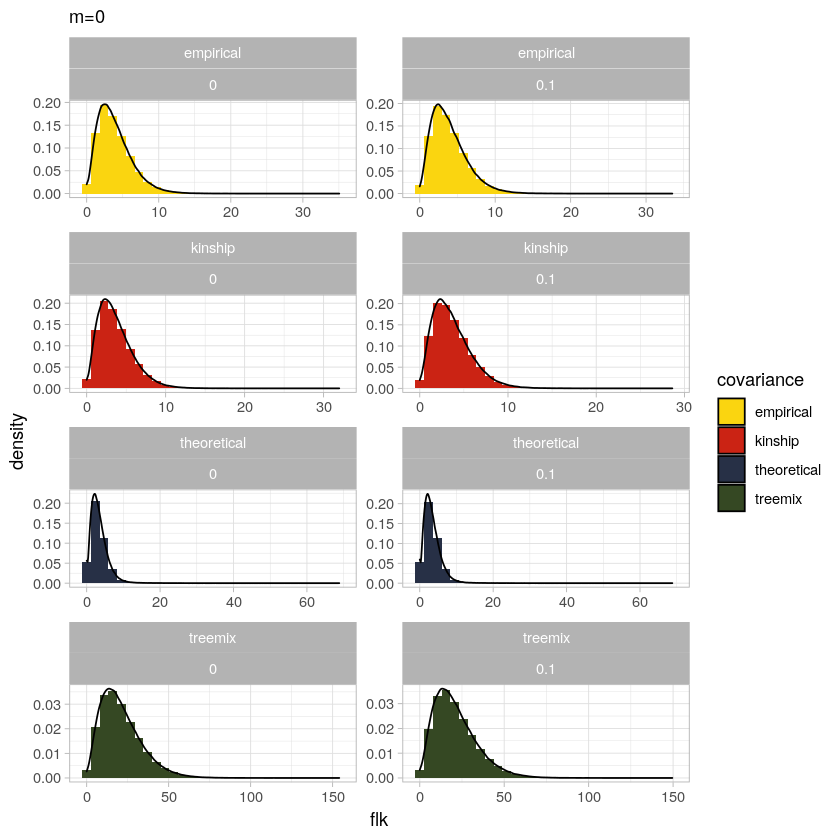

In [20]:
hapflk %>%
    filter(m==0) %>%
    ggplot(aes(x=flk, y = ..density..)) +
    geom_histogram(aes(fill=covariance)) +
    geom_density() +
    facet_wrap(~covariance+s, scales = "free", ncol=2) +
    theme_light() +
    labs(subtitle = paste0("m=",0)) +
    scale_fill_manual(values = colors)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 90406 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 90406 rows containing non-finite values (stat_density).”


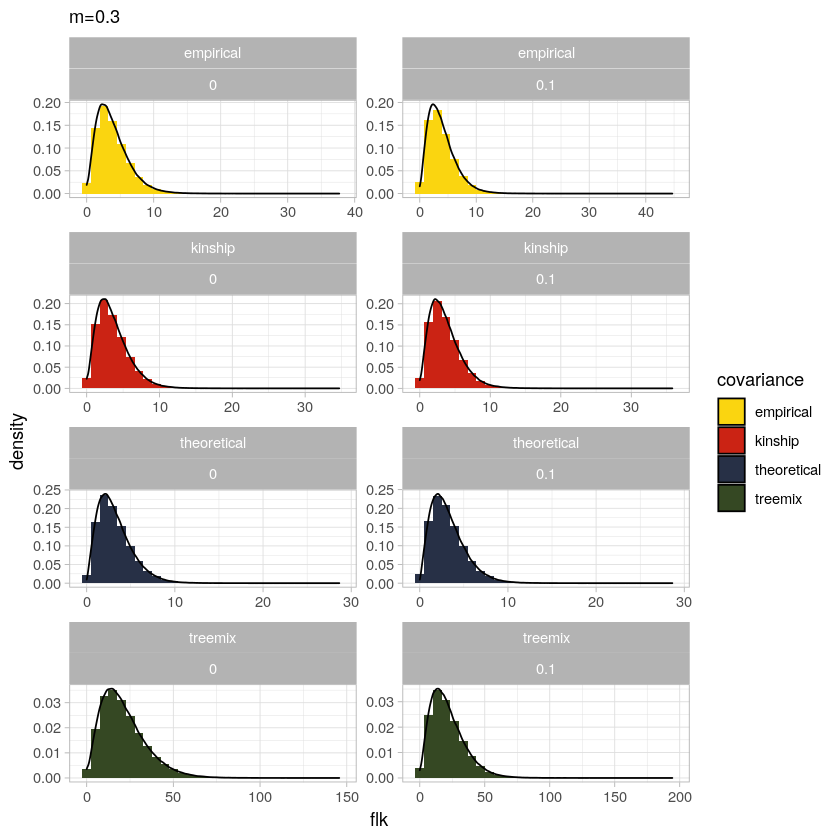

In [21]:
hapflk %>%
    filter(m==0.3) %>%
    ggplot(aes(x=flk, y = ..density..)) +
    geom_histogram(aes(fill=covariance)) +
    geom_density() +
    facet_wrap(~covariance+s, scales = "free", ncol=2) +
    theme_light() +
    labs(subtitle = paste0("m=",0.3)) +
    scale_fill_manual(values = colors)

Now compute values of **hapFLK** for no migration and migration.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



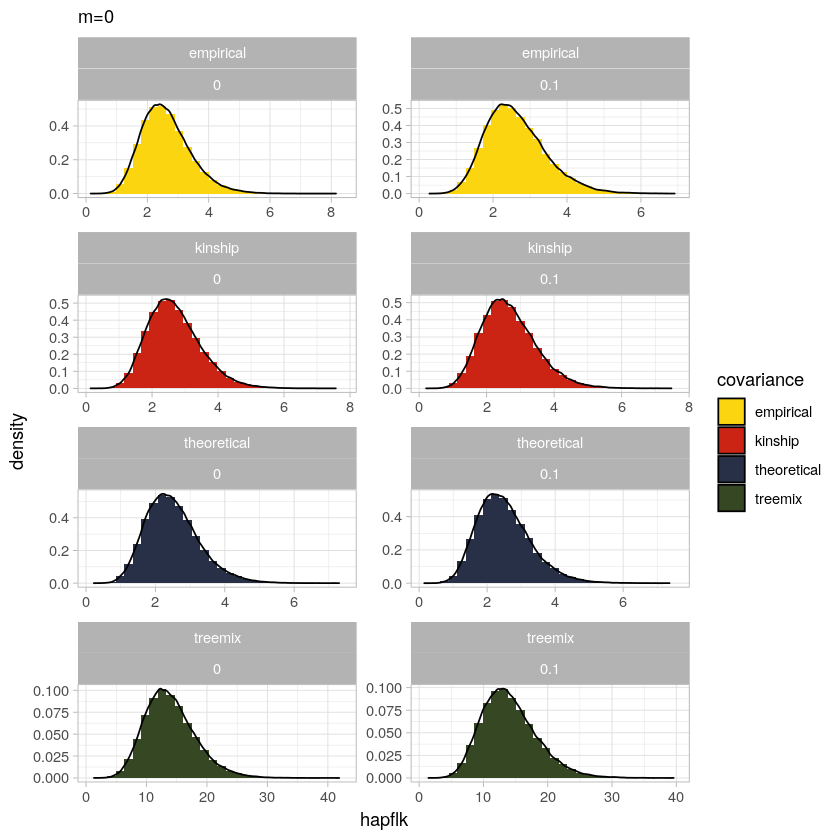

In [22]:
hapflk %>%
    filter(m==0) %>%
    ggplot(aes(x=hapflk, y = ..density..)) +
    geom_histogram(aes(fill=covariance)) +
    geom_density() +
    facet_wrap(~covariance+s, scales = "free", ncol=2) +
    theme_light() +
    labs(subtitle = paste0("m=",0)) +
    scale_fill_manual(values = colors)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



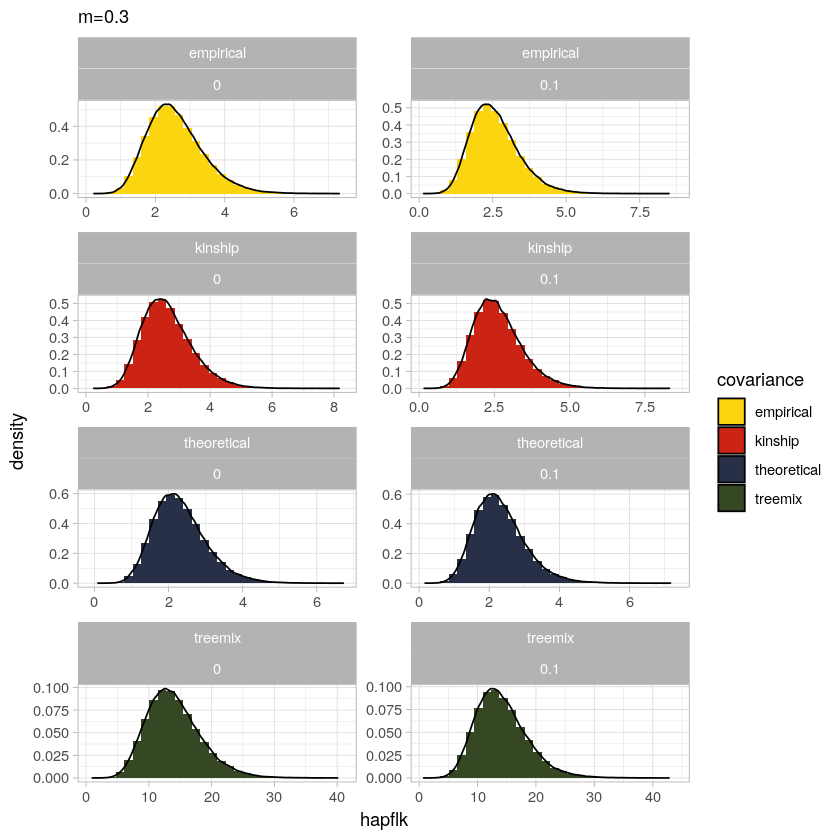

In [23]:
hapflk %>%
    filter(m==0.3) %>%
    ggplot(aes(x=hapflk, y = ..density..)) +
    geom_histogram(aes(fill=covariance)) +
    geom_density() +
    facet_wrap(~covariance+s, scales = "free", ncol=2) +
    theme_light() +
    labs(subtitle = paste0("m=",0.3)) +
    scale_fill_manual(values = colors)

We can more clearly compare the distributions in an overimposed plot. First for the FLK statistic and then for the hapFLK statistic.

Warning message:
“Removed 50713 rows containing non-finite values (stat_density).”


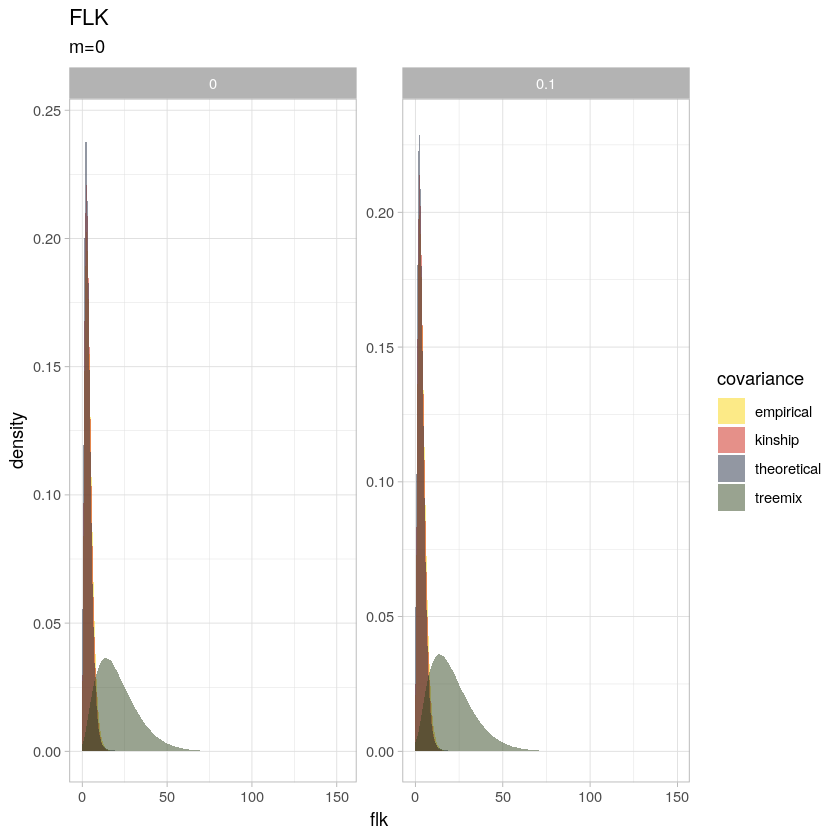

In [24]:
hapflk %>%
    filter(m==0) %>%
    ggplot(aes(x=flk)) +
    geom_density(aes(fill=covariance),color=NA,alpha = 0.5) +
    facet_wrap(~s, scales = "free") +
    labs(subtitle = paste0("m=",0), title="FLK") +
    theme_light() +
    scale_fill_manual(values = colors)

Warning message:
“Removed 90406 rows containing non-finite values (stat_density).”


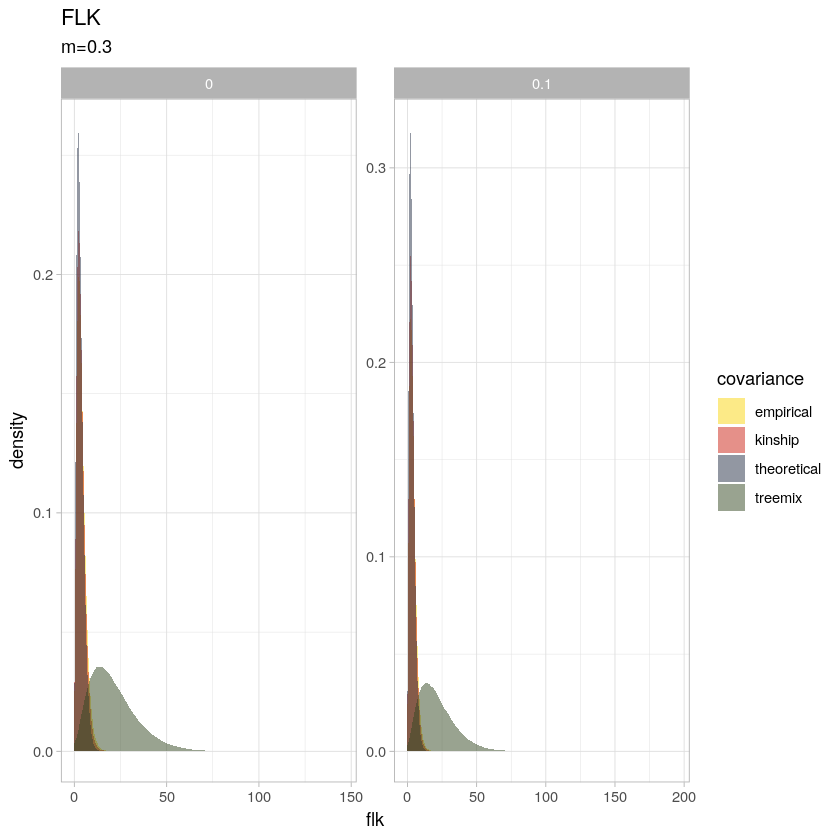

In [25]:
hapflk %>%
    filter(m==0.3) %>%
    ggplot(aes(x=flk)) +
    geom_density(aes(fill=covariance),color=NA,alpha = 0.5) +
    facet_wrap(~s, scales = "free") +
    labs(subtitle = paste0("m=",0.3), title="FLK") +
    theme_light() +
    scale_fill_manual(values = colors)

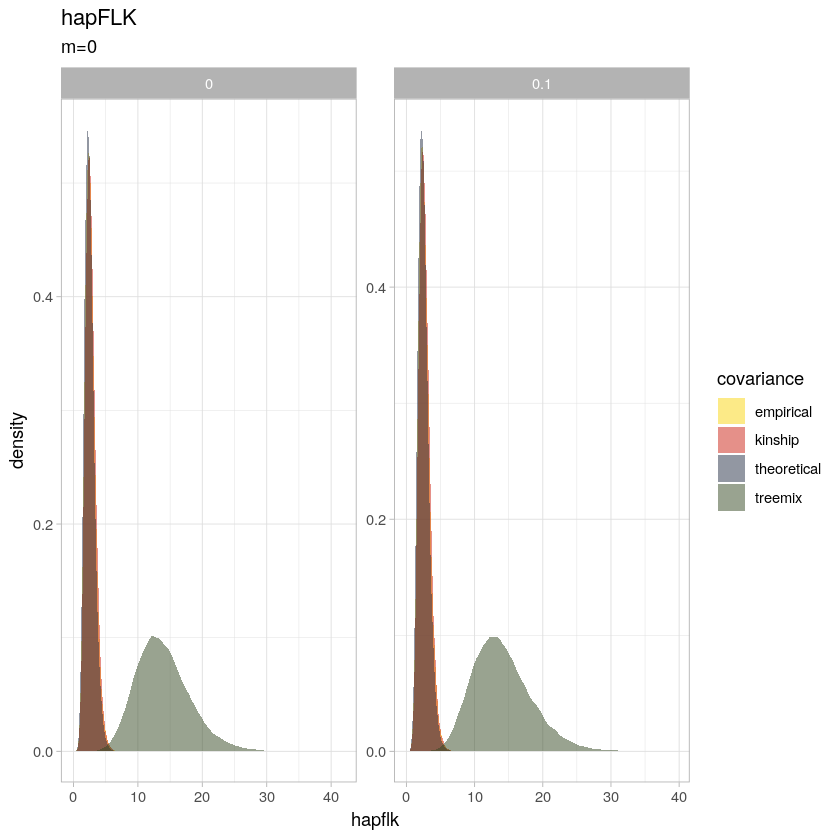

In [26]:
hapflk %>%
    filter(m==0) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance),color=NA,alpha = 0.5) +
    facet_wrap(~s, scales = "free") +
    labs(subtitle = paste0("m=",0), title="hapFLK") +
    theme_light() +
    scale_fill_manual(values = colors)

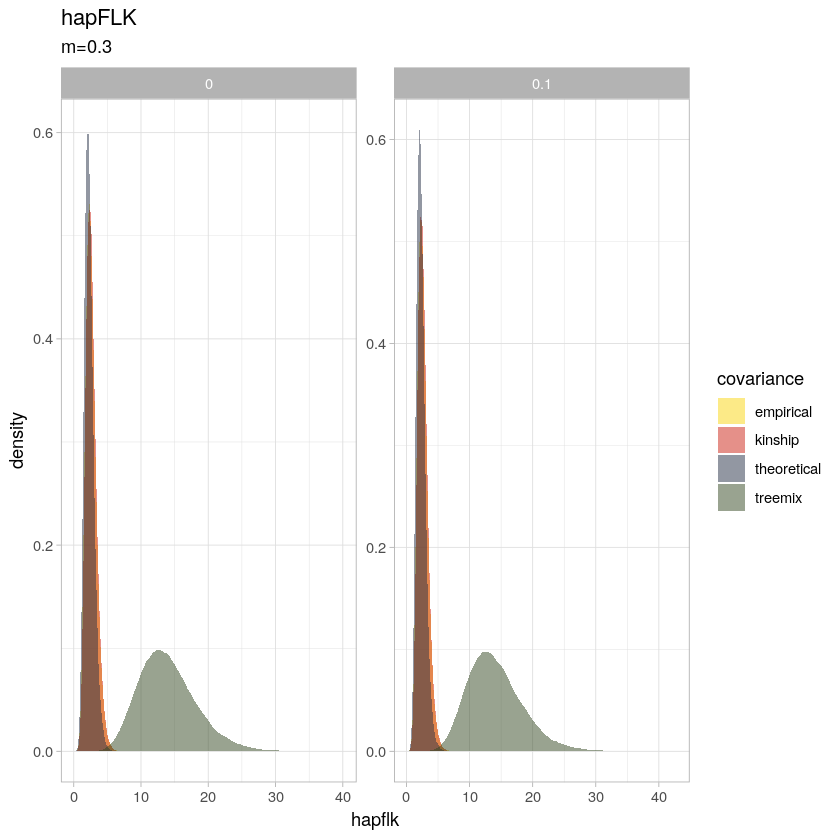

In [27]:
hapflk %>%
    filter(m==0.3) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance),color=NA,alpha = 0.5) +
    facet_wrap(~s, scales = "free") +
    labs(subtitle = paste0("m=",0.3), title="hapFLK") +
    theme_light() +
    scale_fill_manual(values = colors)

All covariance estimation methods look similar except for treemix which appears to be a scaled version of the other ones.

## Statistics goodness-of-fit

### Chi-squared distribution

qqplots are not very informative when superimposed and faceted this way, so let's plot them by m and s, and facet them according to covariance matrices in a square manner. First, define a function to make code more compact.

In [28]:
qqplot_flk <- function(input_df,scoef,mcoef){
    hapflk %>% 
    filter(m==mcoef) %>%
    filter(s==scoef) %>%
    ggplot(., mapping = aes(sample = flk,color = covariance)) +
      stat_qq_band(distribution="chisq",dparams=list("df" = flk_df)) +
      stat_qq_line(distribution="chisq",dparams=list("df" = flk_df)) +
      stat_qq_point(distribution="chisq",dparams=list("df" = flk_df)) +
      facet_wrap(~covariance, scales = "free", ncol=2) +
      labs(subtitle = paste0("m=",mcoef,",","s=",scoef)) +
      xlab("Theoretical Quantiles") +
      ylab("Sample Quantiles") +
      theme_light() +
      ggtitle(bquote("FLK QQ plot "~chi^2~ ~(.(flk_df)))) +
      scale_color_manual(values = colors)
}

In [29]:
#qqplot_flk(hapflk, 0,0)
#qqplot_flk(hapflk, 0.1,0)
#qqplot_flk(hapflk, 0,0.3)
#qqplot_flk(hapflk, 0.1,0.3)

Now compute goodness-of-fit for hapFLK values.

In [30]:
qqplot_hapflk <- function(input_df,scoef,mcoef){
    hapflk %>% 
    filter(m==mcoef) %>%
    filter(s==scoef) %>%
    ggplot(., mapping = aes(sample = hapflk,color = covariance)) +
      stat_qq_band(distribution="chisq",dparams=list("df" = hapflk_df)) +
      stat_qq_line(distribution="chisq",dparams=list("df" = hapflk_df)) +
      stat_qq_point(distribution="chisq",dparams=list("df" = hapflk_df)) +
      facet_wrap(~covariance, scales = "free", ncol=2) +
      labs(subtitle = paste0("m=",mcoef,",","s=",scoef)) +
      xlab("Theoretical Quantiles") +
      ylab("Sample Quantiles") +
      theme_light() +
      ggtitle(bquote("hapFLK QQ plot "~chi^2~ ~(.(hapflk_df)))) +
      scale_color_manual(values = colors)
}

In [31]:
pdf("./qqplots_chisq.pdf")
qqplot_hapflk(hapflk, 0,0)
qqplot_hapflk(hapflk, 0.1,0)
qqplot_hapflk(hapflk, 0,0.3)
qqplot_hapflk(hapflk, 0.1,0.3)
dev.off()

png 
  2

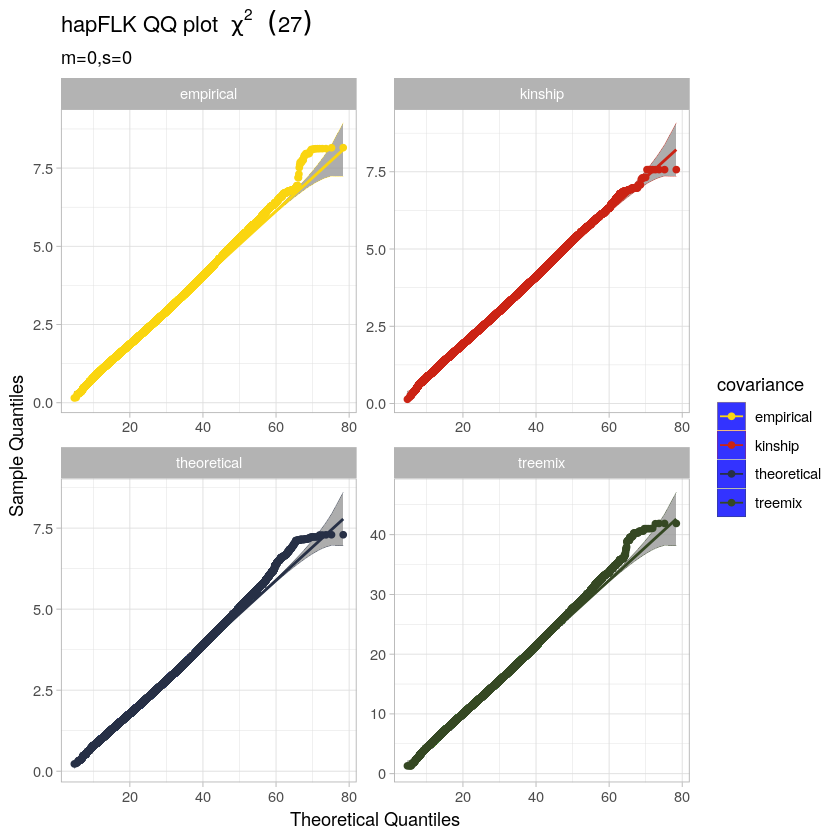

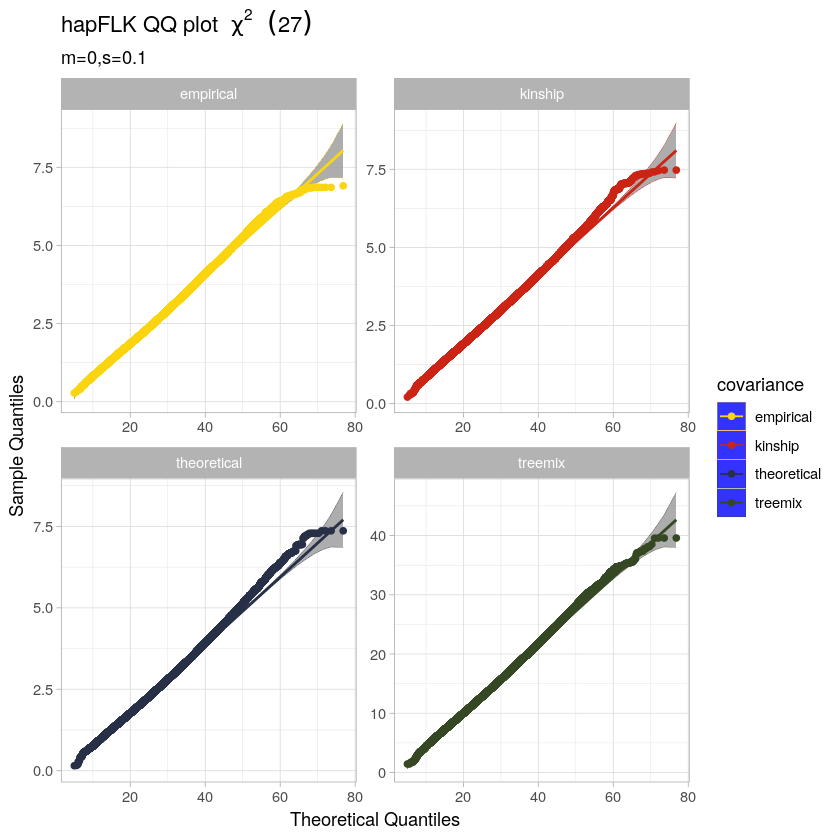

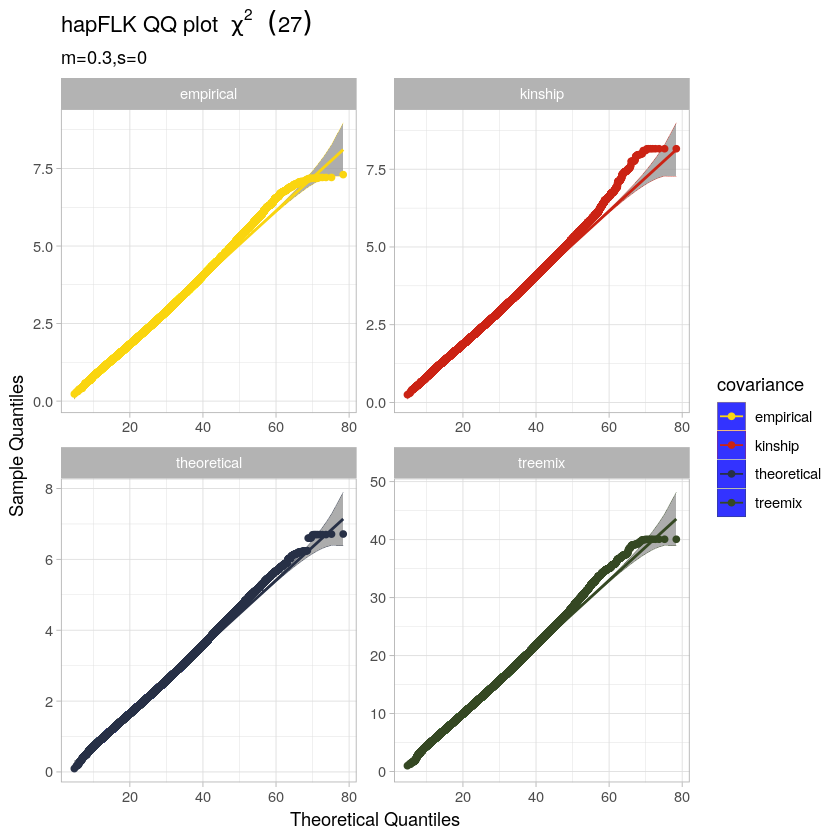

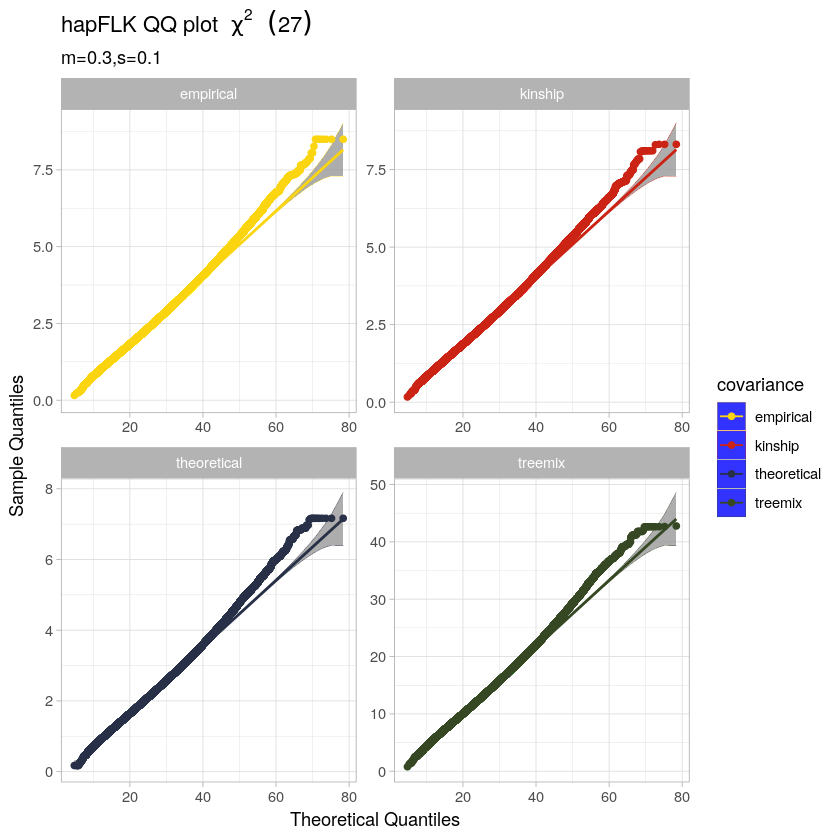

In [32]:
qqplot_hapflk(hapflk, 0,0)
qqplot_hapflk(hapflk, 0.1,0)
qqplot_hapflk(hapflk, 0,0.3)
qqplot_hapflk(hapflk, 0.1,0.3)

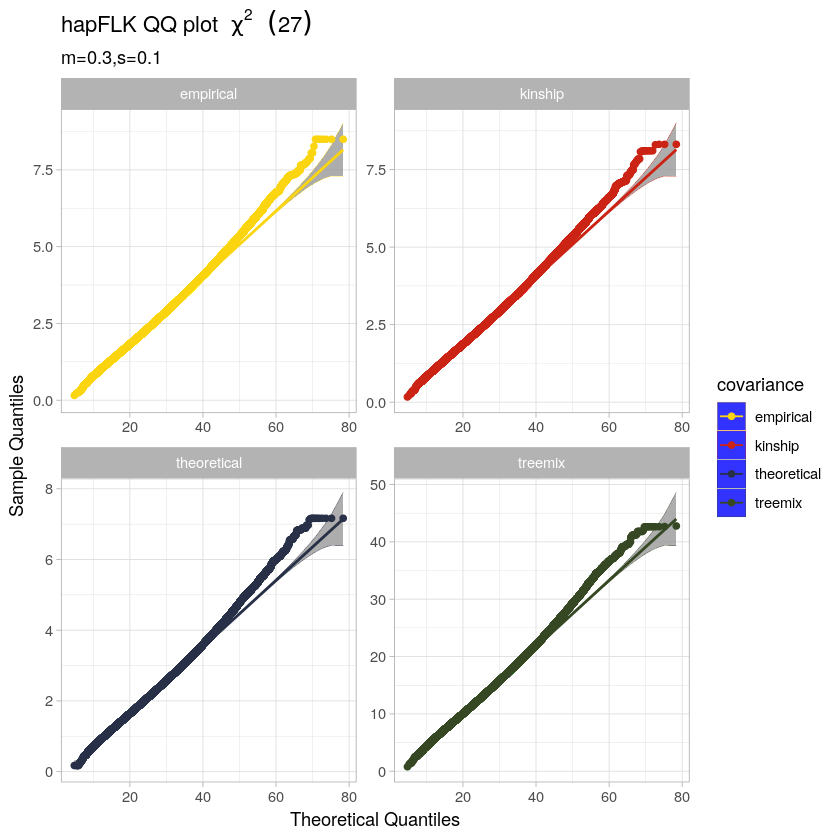

In [33]:
hapflk %>% 
    filter(replicate==9) %>%
    qqplot_hapflk(., 0.1,0.3)

Let’s explore in more detail how good the statistics fit to a χ2 by plotting joint density plots for the empirical and theoretical distributions.

Warning message:
“Removed 632172 rows containing non-finite values (stat_density).”


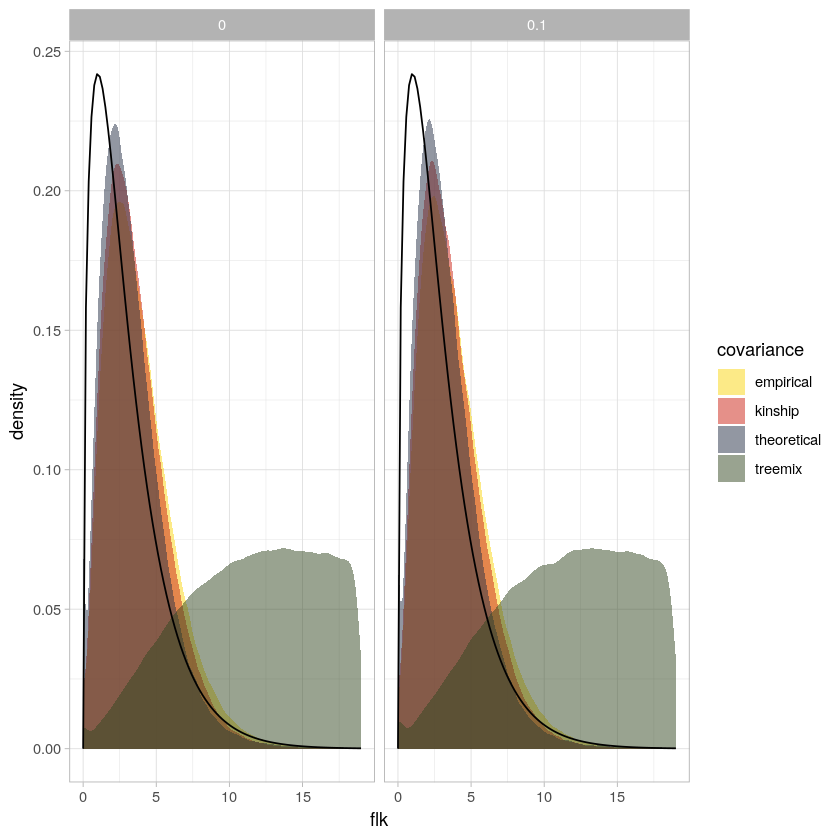

In [34]:
hapflk %>% filter(m==0) %>%
    ggplot(aes(x=flk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5) +
    stat_function(fun = dchisq, args = list(df=flk_df)) +
    xlim(0,max(rchisq(n=1000,df=flk_df))) +
    facet_wrap(~s) +
    theme_light() +
    scale_fill_manual(values = colors)

Warning message:
“Removed 590862 rows containing non-finite values (stat_density).”


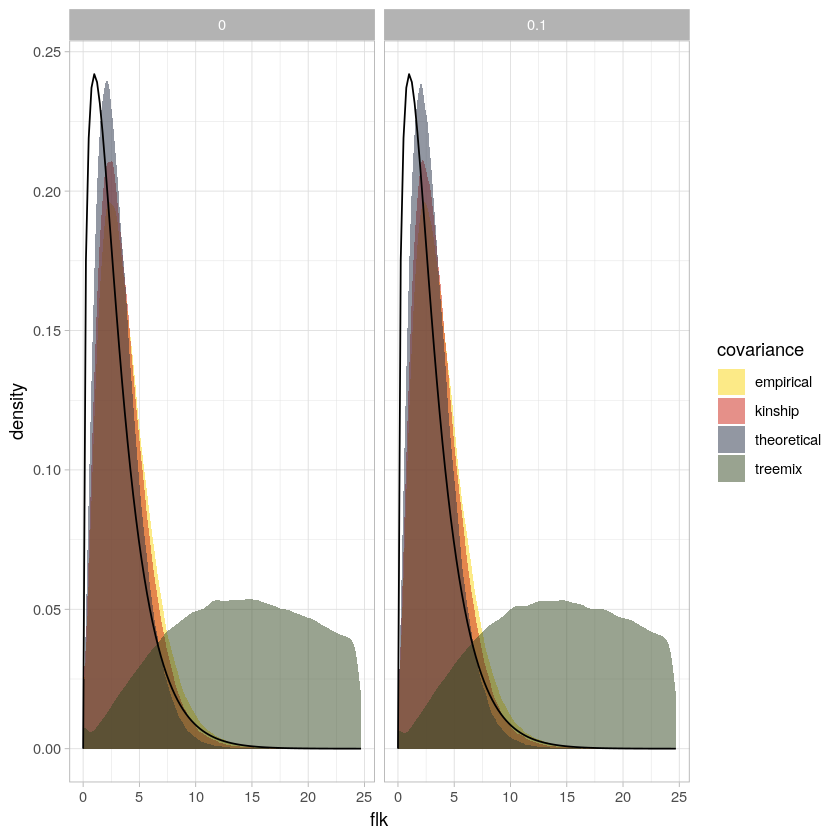

In [35]:
hapflk %>% filter(m==0.3) %>%
    ggplot(aes(x=flk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5) +
    stat_function(fun = dchisq, args = list(df=flk_df)) +
    xlim(0,max(rchisq(n=1000,df=flk_df))) +
    facet_wrap(~s) +
    theme_light() +
    scale_fill_manual(values = colors)

Now, for hapflk statistic.

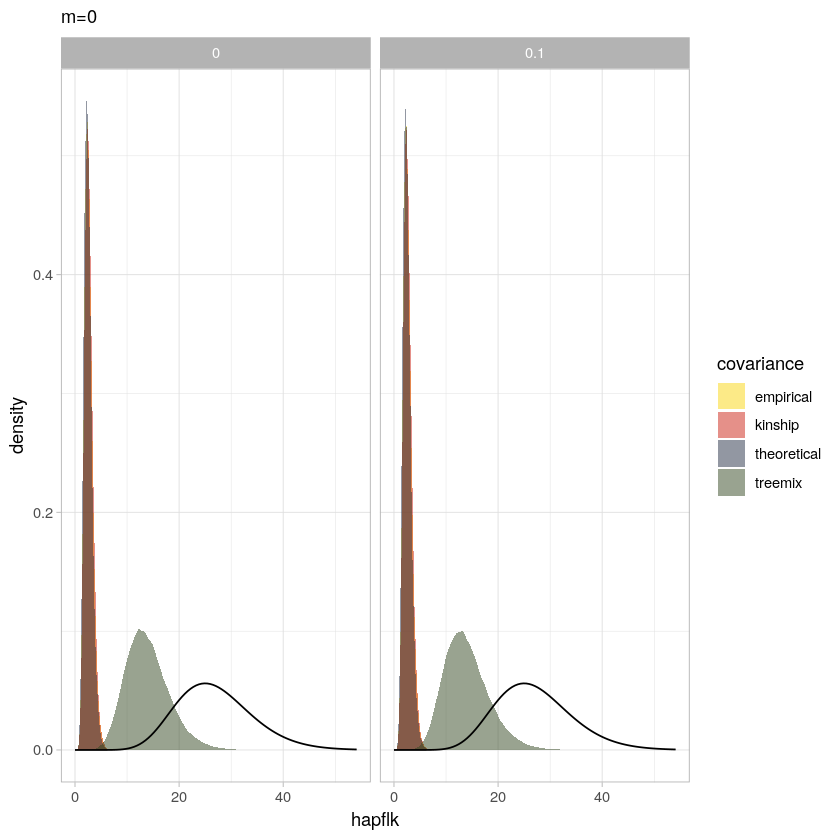

In [10]:
mcoef <- 0
hapflk %>% 
    filter(m==mcoef) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    stat_function(fun = dchisq, args = list(df=hapflk_df)) +
    xlim(0,max(rchisq(n=1000,df=hapflk_df))) +
    labs(subtitle = paste0("m=",mcoef)) +
    facet_wrap(~s) +
    theme_light() +
    scale_fill_manual(values = colors)

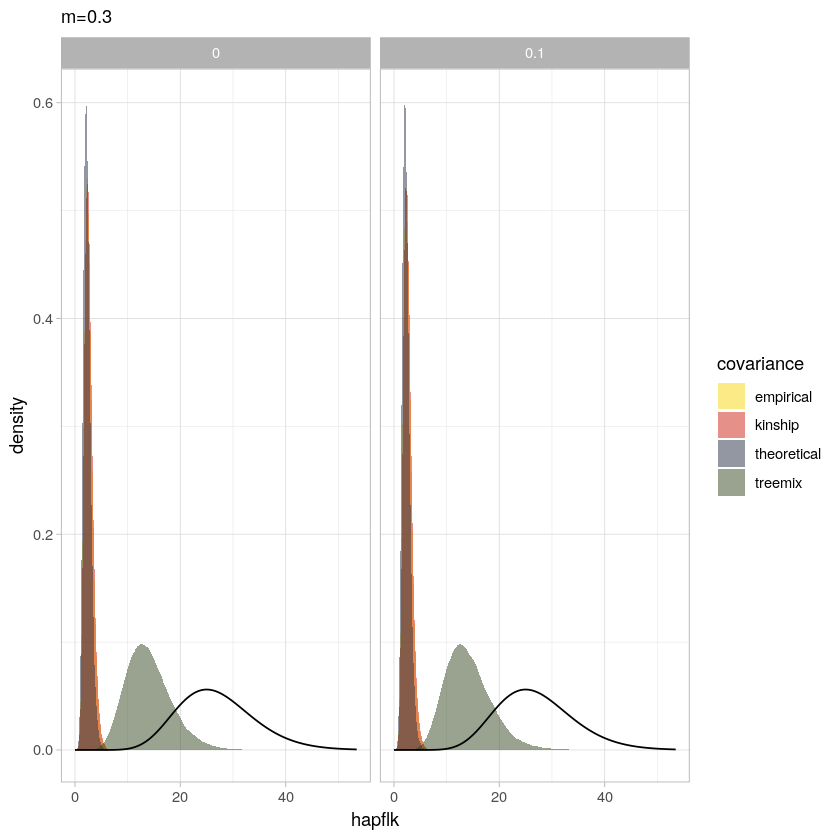

In [11]:
mcoef <- 0.3
hapflk %>% 
    filter(m==mcoef) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    stat_function(fun = dchisq, args = list(df=hapflk_df)) +
    xlim(0,max(rchisq(n=1000,df=hapflk_df))) +
    labs(subtitle = paste0("m=",mcoef)) +
    facet_wrap(~s) +
    theme_light() +
    scale_fill_manual(values = colors)

hapFLK statistic not looking so good.

Assuming the fit is good, lets compute p-values and q-values of hapFLK for each run, plot their distribution, and compare them in manhattan plots.

In [38]:
hapflk <-hapflk %>%
          group_by(covariance,replicate, s,m) %>%
          mutate( pval = 1-pchisq(hapflk, df = hapflk_df) ) %>%
          mutate( qval = p.adjust(pval, method = "fdr")) 

In [39]:
hapflk

replicate s   m   chr pos     flk       covariance hapflk   pval     
1        100       0   0   1    4624   13.149132 treemix    10.72471 0.9977802
2        100       0   0   1    6770   11.986736 treemix    10.72500 0.9977797
3        100       0   0   1    7164   11.986736 treemix    10.72501 0.9977796
4        100       0   0   1   11887    2.427682 treemix    10.73919 0.9977541
5        100       0   0   1   12128    1.505848 treemix    10.73920 0.9977540
6        100       0   0   1   12771    1.505848 treemix    10.73922 0.9977540
7        100       0   0   1   13017    4.962219 treemix    10.84419 0.9975571
8        100       0   0   1   13741          NA treemix    12.32934 0.9929038
9        100       0   0   1   15825   21.101759 treemix    14.32519 0.9778727
10       100       0   0   1   16091   18.785604 treemix    14.32520 0.9778726
11       100       0   0   1   18912   46.126734 treemix    14.87096 0.9712030
12       100       0   0   1   22427   22.760985 treemix    15.42230 0.9630829
13       100       0   0   1   23302   24.480253 treemix    15.47945 0.9621566
14       100       0   0   1   24044   15.804875 treemix    16.66578 0.9390436
15       100       0   0   1   24484   16.026036 treemix    16.66579 0.9390435
16       100       0   0   1   26442   18.119248 treemix    16.77228 0.9365891
17       100       0   0   1   26649   39.516470 treemix    16.75148 0.9370737
18       100       0   0   1   30072   20.888038 treemix    15.67269 0.9589018
19       100       0   0   1   30235   20.436081 treemix    15.67268 0.9589020
20       100       0   0   1   30715   20.436081 treemix    15.67267 0.9589022
21       100       0   0   1   32934    9.307586 treemix    15.67118 0.9589281
22       100       0   0   1   34659   10.937448 treemix    15.65271 0.9592472
23       100       0   0   1   35214   13.595567 treemix    15.65270 0.9592473
24       100       0   0   1   36226   22.883659 treemix    15.65269 0.9592475
25       100       0   0   1   36411   13.595567 treemix    15.65160 0.9592664
26       100       0   0   1   38027   19.141550 treemix    12.09114 0.9939336
27       100       0   0   1   40427   20.610916 treemix    11.42479 0.9961952
28       100       0   0   1   44037   14.764310 treemix    11.57987 0.9957426
29       100       0   0   1   44766    8.441299 treemix    11.65957 0.9954935
30       100       0   0   1   44951    8.441299 treemix    11.65958 0.9954935
⋮        ⋮         ⋮   ⋮   ⋮   ⋮       ⋮         ⋮          ⋮        ⋮        
10815331 9         0.1 0.3 1   9954067 3.9950293 empirical  3.333959 1        
10815332 9         0.1 0.3 1   9954539 6.6784591 empirical  3.325406 1        
10815333 9         0.1 0.3 1   9954921 6.6784591 empirical  3.325406 1        
10815334 9         0.1 0.3 1   9955967 5.2674813 empirical  3.325404 1        
10815335 9         0.1 0.3 1   9958199 5.9468175 empirical  3.272182 1        
10815336 9         0.1 0.3 1   9960855 5.5687009 empirical  3.128953 1        
10815337 9         0.1 0.3 1   9970657 3.8761389 empirical  2.436956 1        
10815338 9         0.1 0.3 1   9975491 4.7606506 empirical  2.025910 1        
10815339 9         0.1 0.3 1   9976930 1.4134172 empirical  2.022650 1        
10815340 9         0.1 0.3 1   9977202 1.3048690 empirical  2.022575 1        
10815341 9         0.1 0.3 1   9977390 1.0912948 empirical  2.021701 1        
10815342 9         0.1 0.3 1   9980760 1.8654963 empirical  2.473116 1        
10815343 9         0.1 0.3 1   9981214 1.4129689 empirical  2.485431 1        
10815344 9         0.1 0.3 1   9982049 2.2195447 empirical  2.523686 1        
10815345 9         0.1 0.3 1   9984284 1.8832238 empirical  2.523706 1        
10815346 9         0.1 0.3 1   9985324 2.3341753 empirical  2.523317 1        
10815347 9         0.1 0.3 1   9985378 2.2539915 empirical  2.523317 1        
10815348 9         0.1 0.3 1   9987714 2.2744876 empirical  2.523359 1        
10815349 9         0.1 0.3 1   9989454 5.4759419 empirical 

Draw p-value histograms

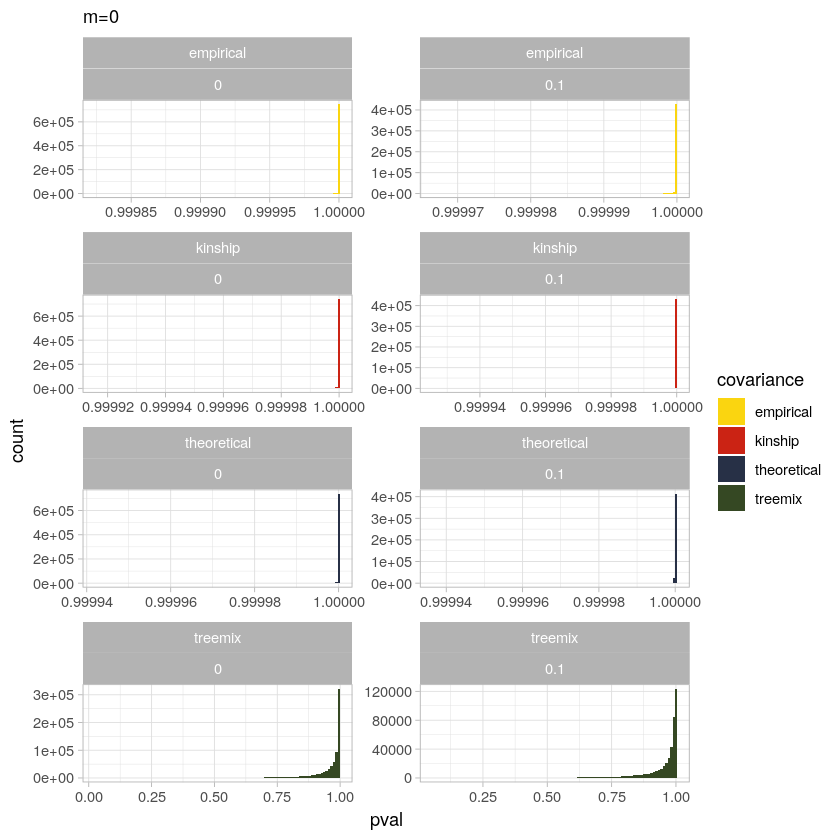

In [40]:
mcoef <- 0 
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins=100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

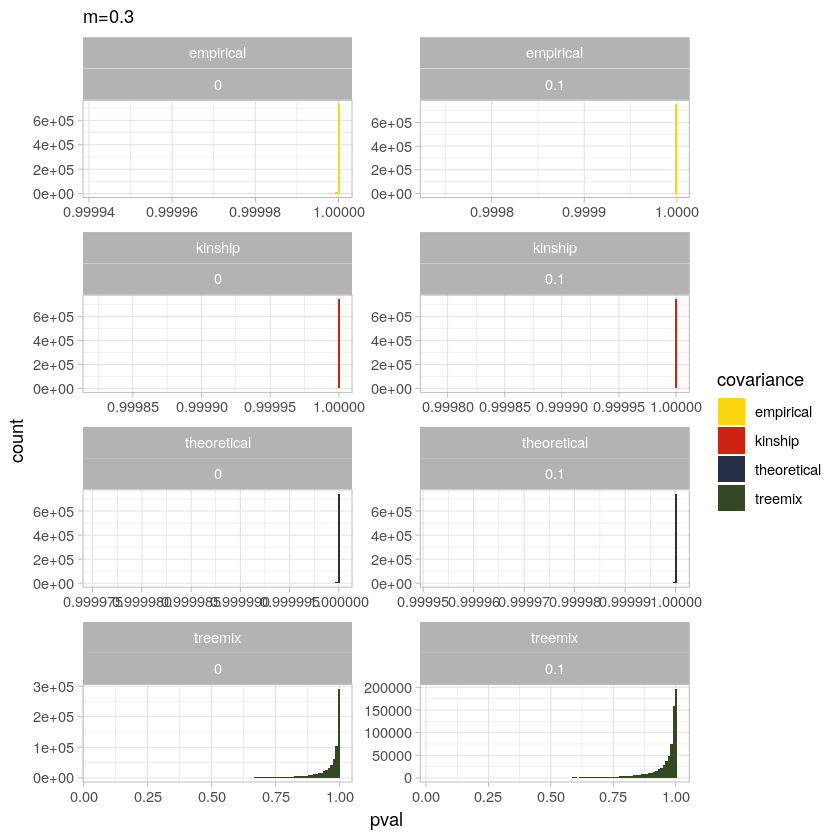

In [41]:
mcoef <- 0.3
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

Let's see p-value manhattan plots

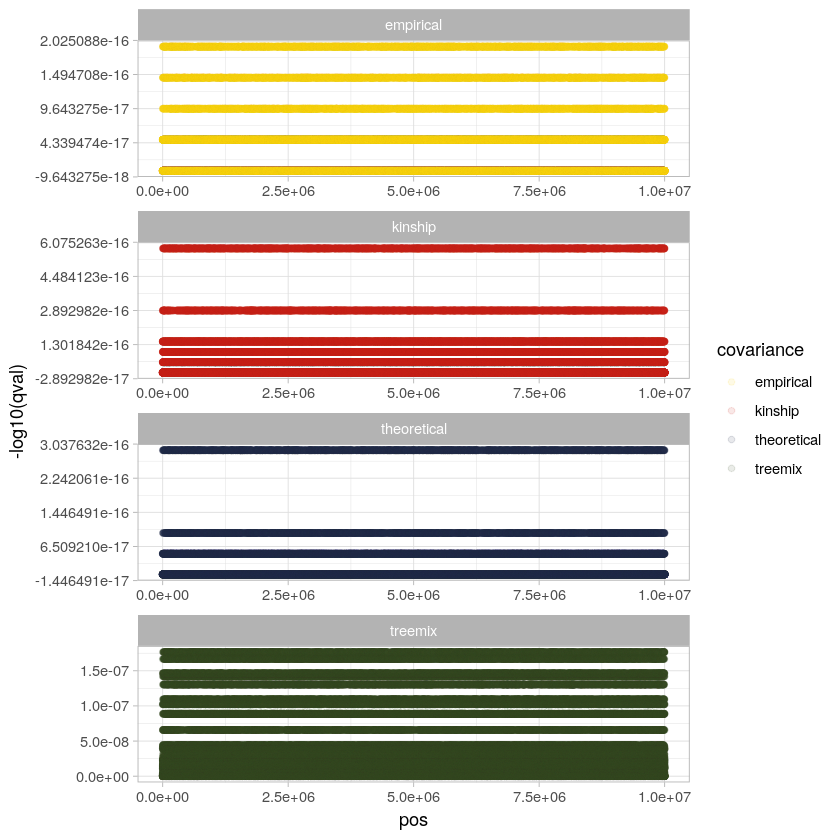

In [42]:
hapflk %>% filter(m==0) %>%
  filter(s==0.1) %>%
  ggplot(., aes(x=pos, y = -log10(qval))) +
  geom_point( aes(color=covariance), alpha = 0.1 ) +
  facet_wrap(~covariance, ncol = 1, scales="free") +
  theme_light()+
  scale_color_manual(values = colors)

### Normal distribution

Same as qqplots for chi-squared distribution, define a function for faceting according to m and s.

In [43]:
qqplot_hapflk_normal <- function(input_df,scoef,mcoef){
    input_df %>% 
    filter(m==mcoef&s==scoef) %>%
    ggplot(., mapping = aes(sample = hapflk,color = covariance)) +
      stat_qq_band() +
      stat_qq_line() +
      stat_qq_point() +
      labs(subtitle = paste0("m=",mcoef,",","s=",scoef)) +
      facet_wrap(~covariance, scales = "free") +
      xlab("Theoretical Quantiles") +
      ylab("Sample Quantiles") +
      theme_light() +
      ggtitle(bquote("hapFLK QQ plot "~N(mu,sigma) )) +
      scale_color_manual(values = colors)
}

In [44]:
pdf("./qqplots_normal.pdf")
qqplot_hapflk_normal(hapflk, 0,0)
qqplot_hapflk_normal(hapflk, 0.1,0)
qqplot_hapflk_normal(hapflk, 0,0.3)
qqplot_hapflk_normal(hapflk, 0.1,0.3)
dev.off()

png 
  2

I could visualize the Kernel Density Estimates together with the theoretical distributions. But I won't do it right now.

Assuming hapFLK follows a normal distribution, compute p-values and q-values. Make p values histograms and Manhattan plots.


In [45]:
hapflk <- hapflk %>% 
          group_by( replicate, covariance, s,m ) %>%
          mutate( pval = 1- pnorm(hapflk , mean(hapflk),sd(hapflk))  ) %>%
          mutate( qval = p.adjust(pval, "fdr"))

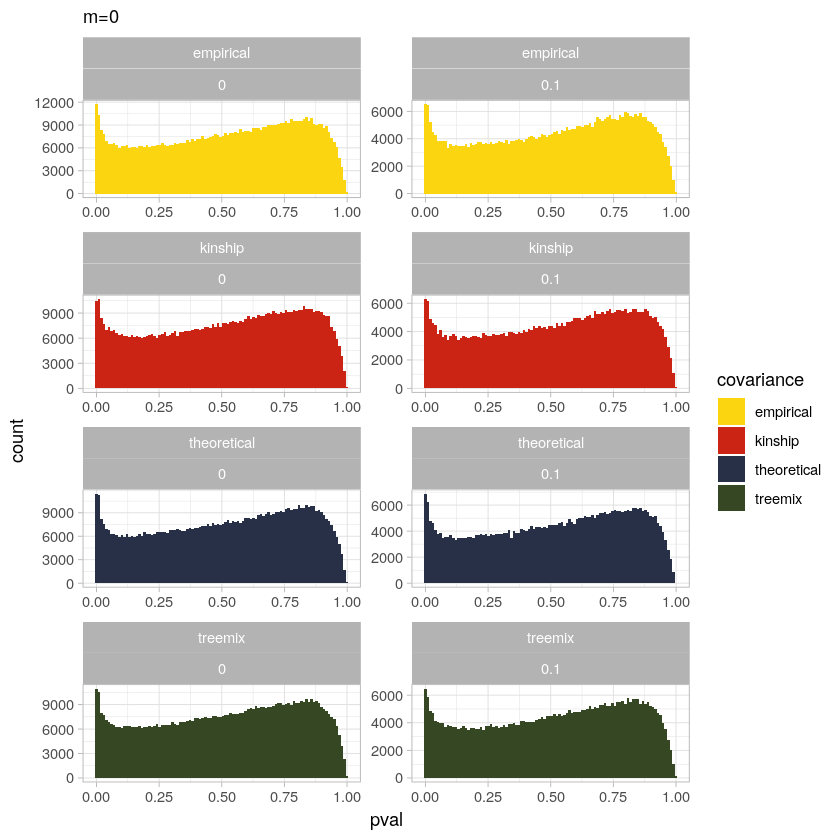

In [46]:
mcoef <- 0.0
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

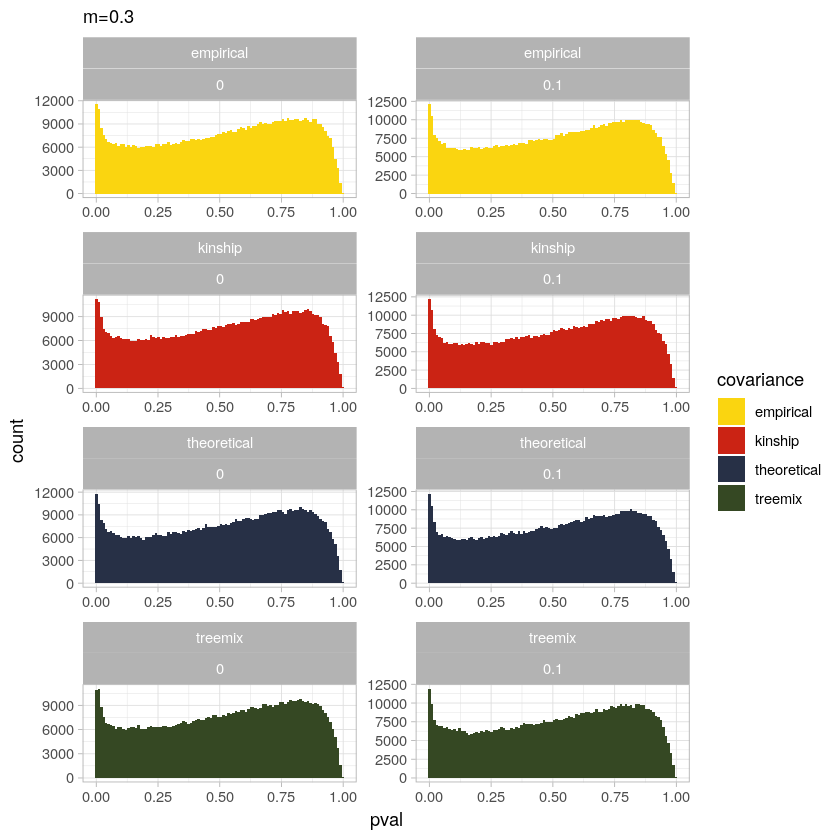

In [47]:
mcoef <- 0.3
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

Manhattan plots now (only for selection scenarios)

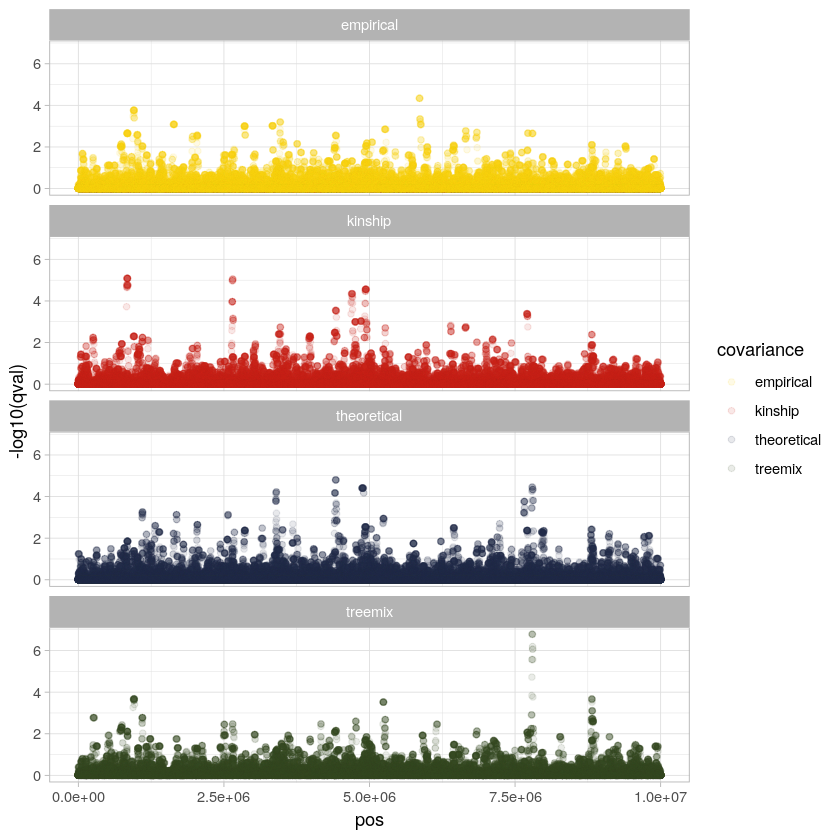

In [48]:
hapflk %>% filter(m==0) %>%
  filter(s==0.1) %>%
  ggplot(., aes(x=pos, y = -log10(qval))) +
  geom_point( aes(color=covariance), alpha = 0.1 ) +
  facet_wrap(~covariance, ncol = 1) +
  theme_light()+
  scale_color_manual(values = colors)

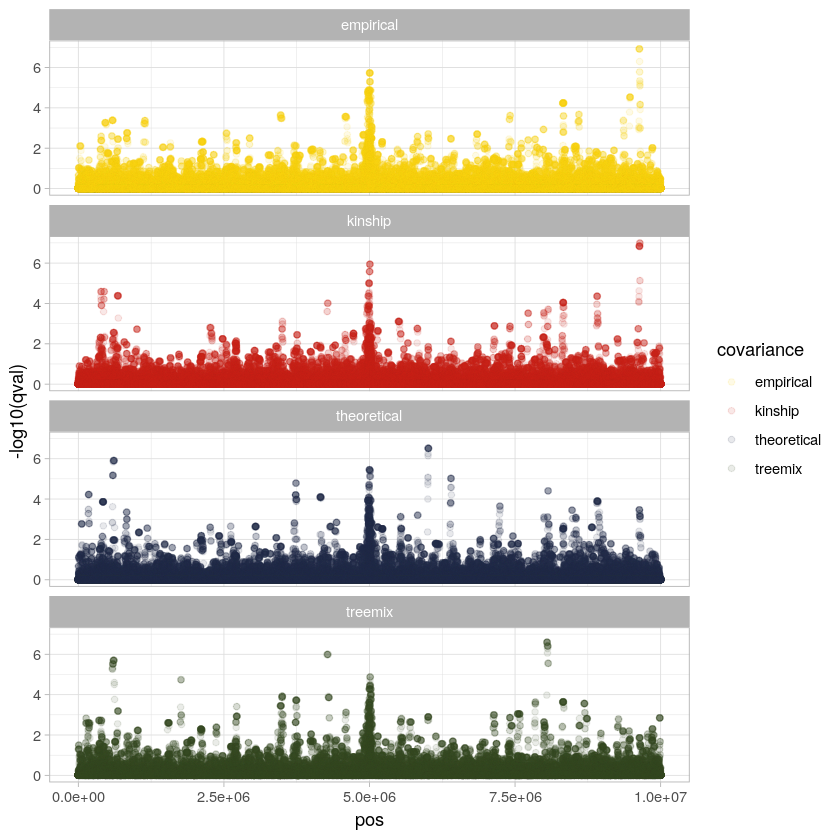

In [49]:
hapflk %>% filter(m==0.3) %>%
  filter(s==0.1) %>%
  ggplot(., aes(x=pos, y = -log10(qval))) +
  geom_point( aes(color=covariance), alpha = 0.1 ) +
  facet_wrap(~covariance, ncol = 1) +
  theme_light()+
  scale_color_manual(values = colors)

The above p-values are computed using the mean and standard deviation, which are sensistive to the presence of outliers. We can estimate the mean and standard deviation more robustly using the rlm() function for robust linear models estimation.

Compute p-values

In [50]:
hapflk <- hapflk %>% 
    group_by(replicate,covariance, s,m ) %>%
    mutate( pval = 1 - pnorm( hapflk , 
                 mean= MASS::rlm(hapflk~1)$coefficients[1], 
                 sd = MASS::rlm(hapflk~1)$s )) %>% 
    mutate(qval = p.adjust(pval,"fdr")) 

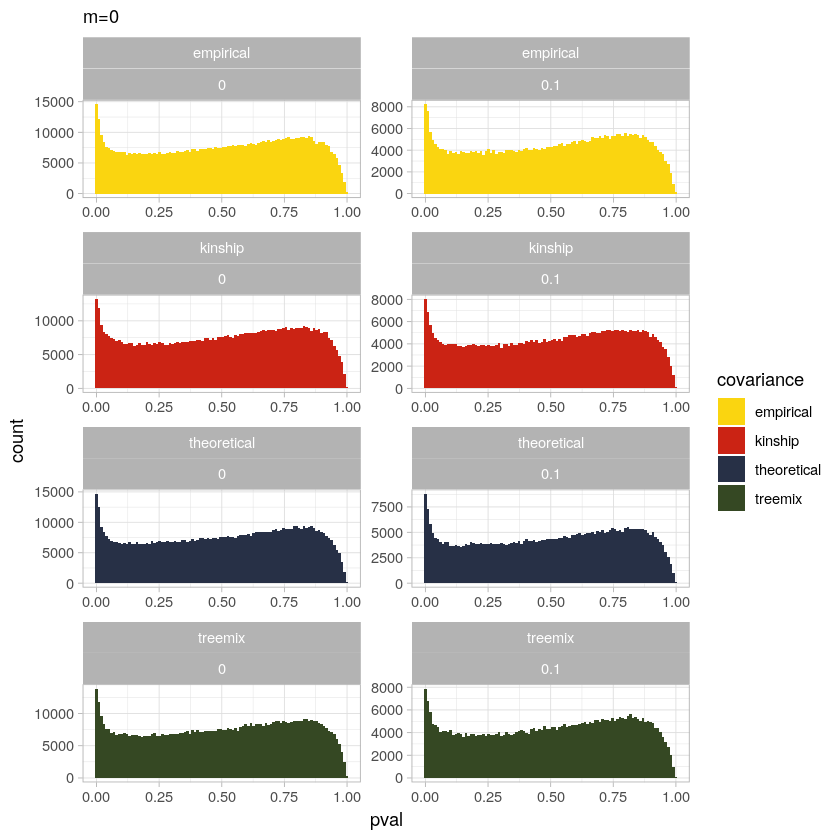

In [51]:
mcoef <- 0.0
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

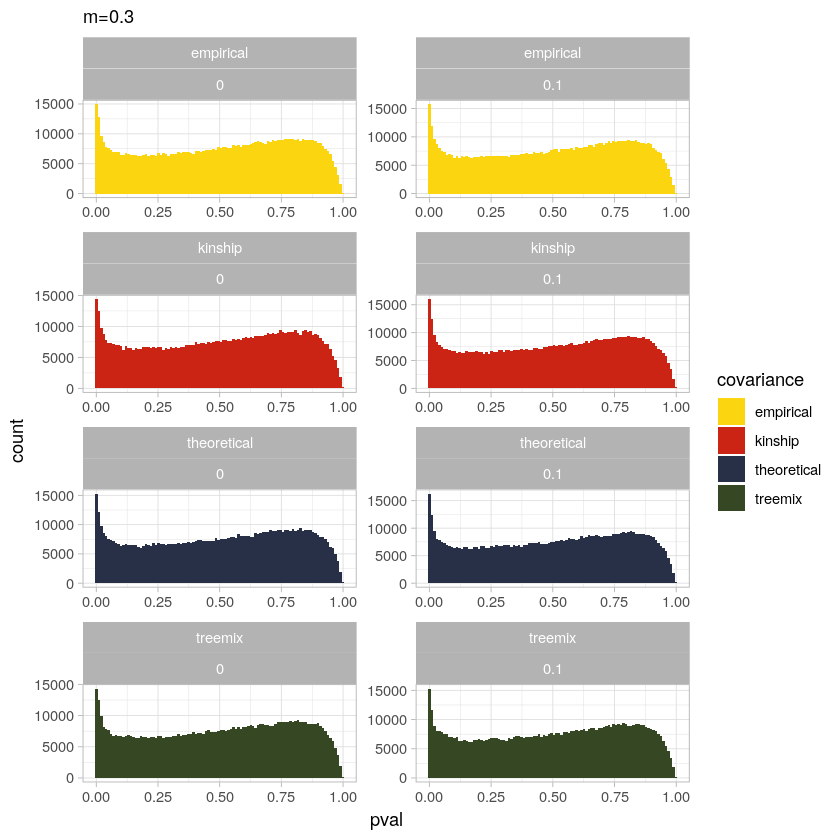

In [52]:
mcoef <- 0.3
hapflk %>% filter(m==mcoef) %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

Manhattan plots for selection

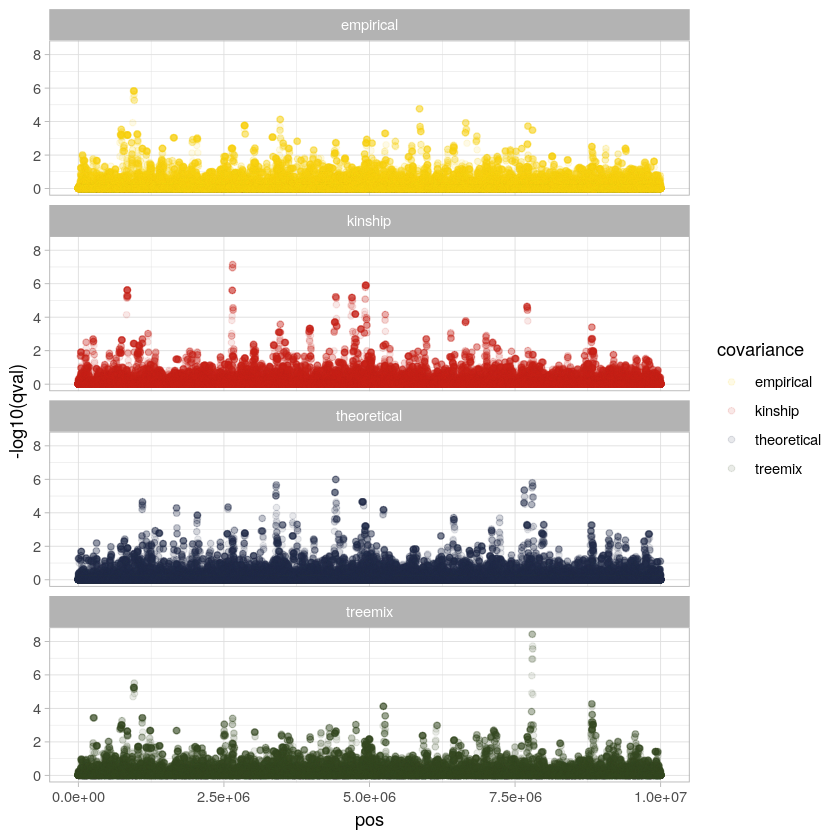

In [53]:
hapflk %>% filter(m==0) %>%
  filter(s==0.1) %>%
  ggplot(., aes(x=pos, y = -log10(qval))) +
  geom_point( aes(color=covariance), alpha = 0.1 ) +
  facet_wrap(~covariance, ncol = 1) +
  theme_light()+
  scale_color_manual(values = colors)

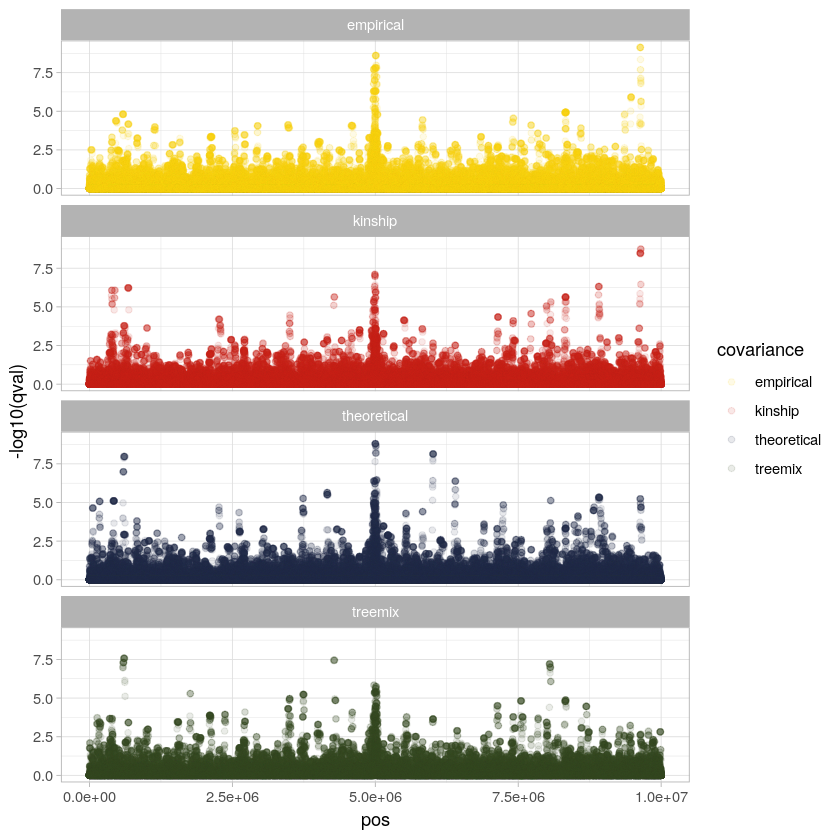

In [54]:
hapflk %>% filter(m==0.3) %>%
  filter(s==0.1) %>%
  ggplot(., aes(x=pos, y = -log10(qval))) +
  geom_point( aes(color=covariance), alpha = 0.1 ) +
  facet_wrap(~covariance, ncol = 1) +
  theme_light()+
  scale_color_manual(values = colors)

## Raw statistics Manhattan plots

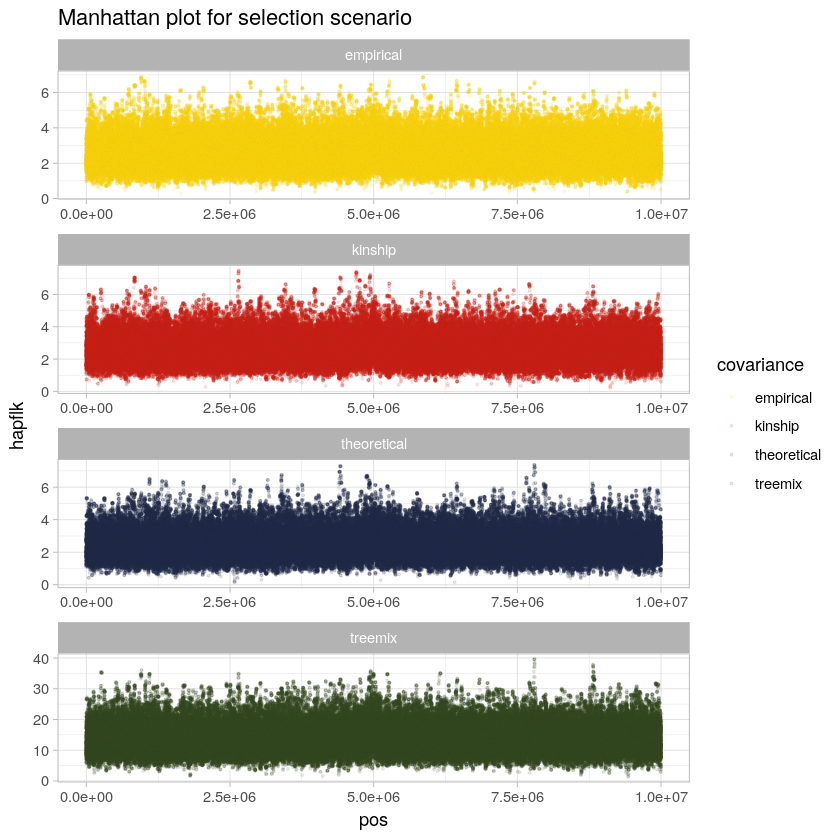

In [55]:
hapflk %>% filter(m==0) %>%
filter(s==0.1) %>%
    ggplot(aes(x=pos, y = hapflk, color = covariance)) +
    geom_point(size  = 0.5, alpha = 0.1) +
    facet_wrap(~covariance, ncol = 1, scales = "free") +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plot for selection scenario")

In [ ]:
hapflk %>% filter(m==0.3) %>%
filter(s==0.1) %>%
    ggplot(aes(x=pos, y = hapflk, color = covariance)) +
    geom_point(size  = 0.5, alpha = 0.1) +
    facet_wrap(~covariance, ncol = 1, scales = "free") +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plot for selection scenario")

## Chi squared rescaling for hapFLK

hapFLK values will be rescaled with theoretical values (for given degrees of freedom (npop−1)(K−1) using quantile (robust) regression.

In [ ]:
# function for computing scaled values
qReg <- function(x, probs = seq(0,1-0.01,0.01),df){
    # Compute empirical quantiles
    eq <- quantile(x, probs=probs)
    # Compute theoretical quantiles
    tq  <- qchisq(probs, df=df ) 
    # Fit a robust linear model
    fit  <- MASS::rlm(tq~eq, maxit=100)
    # Get coefficients
    b <- fit$coefficients[1]
    a <- fit$coefficients[2]
    # Return scaled values
    y_hat <- x*a + b
    return(y_hat)
}

In [ ]:
hapflk <- hapflk %>%
    group_by(replicate, covariance, s,m) %>%
    rename(unscaled="hapflk") %>%
    mutate(scaled=qReg(unscaled, df = hapflk_df) ) %>%
    pivot_longer(cols = c("unscaled", "scaled"),
                 names_to = "scaling",
                 values_to = "hapflk" ) %>%
    group_by(replicate,covariance,scaling, s,m) %>%
    mutate(pval = 1- pchisq(hapflk, df = hapflk_df ) ) %>%
    mutate(qval = p.adjust(pval, method = "fdr" ) ) %>%
    ungroup()

In [ ]:
hapflk

Let's compare the rescaled density estimates with unscaled estimates, together with the theoretical chi-squared distribution.

For no migration:

In [ ]:
hapflk %>% filter(m==0) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    stat_function(fun = dchisq, args = list(df=hapflk_df)) +
    xlim(0,max(rchisq(n=100,df=hapflk_df))) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

For migration:

In [ ]:
hapflk %>% filter(m==0.3) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    stat_function(fun = dchisq, args = list(df=hapflk_df)) +
    xlim(0,max(rchisq(n=100,df=hapflk_df))) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

Scaling seems to work pretty well, lets draw p-value histograms and manhattan plots to see if everything behaves as expected

p-value histograms for m=0

In [ ]:
mcoef <- 0.0
hapflk %>% filter(m==mcoef) %>%
            filter(scaling=="scaled") %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

In [ ]:
mcoef <- 0.3
hapflk %>% filter(m==mcoef) %>%
            filter(scaling=="scaled") %>%
            ggplot() + 
            geom_histogram(aes(x=pval,fill=covariance), color = NA,bins = 100 ) + 
            facet_wrap(~covariance+s, ncol=2, scales = "free") + 
            theme_light()+ 
            labs(subtitle = paste0("m=",mcoef)) +
            scale_fill_manual(values = colors) 

In [ ]:
s_1 <- hapflk %>% filter(s==0,m==0) %>%
        ggplot(aes(x=pval, fill = covariance)) +
        geom_histogram(alpha=0.7) +
        facet_wrap(~s+covariance, ncol = 2) +
        scale_fill_manual(values = colors) +
        theme_light() +
        ggtitle("p-values distributions for neutral scenario")
s_2 <- hapflk %>% filter(s==0.1,m==0) %>%
        ggplot(aes(x=pval, fill = covariance)) +
        geom_histogram(alpha=0.7) +
        facet_wrap(~s+covariance, ncol = 2) +
        scale_fill_manual(values = colors) +
        theme_light() +
        ggtitle("p-values distributions for selection scenario")
grid.arrange(s_1,s_2)

p-value histograms for m=0.3

In [ ]:
s_1 <- hapflk %>% filter(s==0,m==0.3) %>%
        ggplot(aes(x=pval, fill = covariance)) +
        geom_histogram(alpha=0.7) +
        facet_wrap(~s+covariance, ncol = 2) +
        scale_fill_manual(values = colors) +
        theme_light() +
        ggtitle("p-values distributions for neutral scenario")
s_2 <- hapflk %>% filter(s==0.1,m==0.3) %>%
        ggplot(aes(x=pval, fill = covariance)) +
        geom_histogram(alpha=0.7) +
        facet_wrap(~s+covariance, ncol = 2) +
        scale_fill_manual(values = colors) +
        theme_light() +
        ggtitle("p-values distributions for selection scenario")
grid.arrange(s_1,s_2)

Manhattan plots for m=0

In [ ]:
hapflk %>% filter(m==0&s==0) %>%   
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for neutral scenario")

In [ ]:
hapflk %>% filter(m==0&s==0.1) %>%   
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for selection scenario")

Manhattan plots for m=0.3

In [ ]:
hapflk %>% filter(m==0.3&s==0) %>%   
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for neutral scenario")

In [ ]:
hapflk %>% filter(m==0.3&s==0.1) %>%   
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for selection scenario")

## Normal robust rescaling of hapFLK values

In [ ]:
# Define scaling function
normalScaling <- function( x ){
    
    # Compute robust estimates of mean and sd
    fit <- MASS::rlm(x~1)
    mu <- fit$coefficients[1]
    s <- fit$s
    y_hat <- (x - mu) / s
    return(y_hat)
    
}

In [ ]:
# Wrangle for removing chi squared statistics

hapflk <- hapflk %>% dplyr::select(-qval,-pval) %>%
        filter(scaling == "unscaled" ) %>%
        pivot_wider(names_from="scaling", values_from = "hapflk")

In [ ]:
# Compute p values
hapflk <- hapflk %>%
    group_by(replicate, covariance, s,m) %>%
    mutate(scaled=normalScaling(unscaled) ) %>%
    pivot_longer(cols = c("unscaled", "scaled"),
                 names_to = "scaling",
                 values_to = "hapflk" ) %>%
    group_by(replicate,covariance,scaling,s,m) %>%
    mutate(pval = 1- pnorm(hapflk,
                           mean=MASS::rlm(hapflk~1)$coefficients[1],
                           sd = MASS::rlm(hapflk~1)$s ) ) %>%
    mutate(qval = p.adjust(pval, method = "fdr" ) ) 

We should visualize and compared the computed scaled densities with unscaled densities.

First, m=0

In [ ]:
hapflk %>% filter(m==0&s==0) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

In [ ]:
hapflk %>% filter(m==0&s==0.1) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

Now, m=0.1

In [ ]:
hapflk %>% filter(m==0&s==0) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

In [ ]:
hapflk %>% filter(m==0.3&s==0.1) %>%
    ggplot(aes(x=hapflk)) +
    geom_density(aes(fill=covariance), color = NA, alpha = 0.5,trim = TRUE  ) +
    facet_wrap(~s+scaling) +
    theme_light() +
    scale_fill_manual(values = colors)

What about p-value distributions?

For m=0

In [ ]:
hapflk %>% filter(m==0&s==0) %>%
    ggplot(aes(x=pval, fill = covariance)) +
    geom_histogram(alpha=0.7) +
    facet_wrap(~s+covariance, ncol = 2) +
    scale_color_manual(values = colors) +
    theme_light() +
    ggtitle("p-values distributions for neutral scenario")

In [ ]:
hapflk %>% filter(m==0&s==0.1) %>%
    ggplot(aes(x=pval, fill = covariance)) +
    geom_histogram(alpha=0.7) +
    facet_wrap(~s+covariance, ncol = 2) +
    scale_color_manual(values = colors) +
    theme_light() +
    ggtitle("p-values distributions for selection scenario")

For m=0.3

In [ ]:
hapflk %>% filter(m==0.3&s==0) %>%
    ggplot(aes(x=pval, fill = covariance)) +
    geom_histogram(alpha=0.7) +
    facet_wrap(~s+covariance, ncol = 2) +
    scale_color_manual(values = colors) +
    theme_light() +
    ggtitle("p-values distributions for neutral scenario")

In [ ]:
hapflk %>% filter(m==0.3&s==0.1) %>%
    ggplot(aes(x=pval, fill = covariance)) +
    geom_histogram(alpha=0.7) +
    facet_wrap(~s+covariance, ncol = 2) +
    scale_color_manual(values = colors) +
    theme_light() +
    ggtitle("p-values distributions for selection scenario")

And now, for everyone's delight, Manhtattan plots!

For m=0

In [ ]:
hapflk %>% filter(m==0&s==0) %>%
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for neutral scenario")

In [ ]:
hapflk %>% filter(m==0&s==0.1) %>%
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for selection scenario")

For m=0.3

In [ ]:
hapflk %>% filter(m==0.3&s==0) %>%
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for neutral scenario")

In [ ]:
hapflk %>% filter(m==0.3&s==0.1) %>%
ggplot(aes(x=pos, y = -log10(qval), color = covariance )) +
    geom_point(alpha = 0.3, size = 0.5) +
    facet_wrap(~covariance+scaling, ncol = 2) +
    theme_light() +
    scale_color_manual(values = colors) +
    ggtitle("Manhattan plots for selection scenario")

## Power analysis

Deine functions for power analysis and plotting

In [ ]:
computePower <- function( quantile, null, empirical ){
    null <- rev(null)
    sum(empirical > null[quantile] ) / length(empirical)
}

In [ ]:
computeROC <- function( input_df, mcoef ){
    
    max_stats<- input_df %>% 
        filter(m==mcoef) %>%
        group_by( replicate, covariance, s ) %>%
        summarise(Smax=max(hapflk))
    # Define global variables
    null_global <- max_stats %>% filter(s==0) 
    selection_global <- max_stats %>% filter(s!=0) 
    alpha <- seq(0,1,0.01)
    quantiles <- 1:length(alpha)
    # Allocate dataframe
    
    df <- data.frame(alpha) %>% as_tibble()
    # Define groupings
    covariances <- max_stats %>%
        dplyr::select(covariance) %>%
        distinct() %>%
        pull(covariance)
    
    
    for ( i in covariances ){
        
        null <- null_global %>%
            filter(covariance == i ) %>%
            pull(Smax)
        selection <- selection_global %>%
            filter(covariance == i ) %>%
            pull(Smax)
        
        qnull <- quantile(null, probs = alpha )
        power <- sapply(quantiles,
                        FUN = computePower,
                        empirical = selection,
                        null = qnull )
        
        df[i] <- power
        
    }
    
    
    df <- df %>%
        pivot_longer(cols = all_of(covariances),
                     names_to = "covariance",
                     values_to = "power"
        )
    
    return(df)
    
}

In [ ]:
plotROC <- function(df, mcoef){
    
    auc <- df %>%
        group_by(covariance) %>% 
        summarise(AUC=sum(power)) %>%
        arrange(desc(AUC))
    df %>%
        ggplot( aes(x=alpha, y = power) ) +
        geom_path(aes(color = covariance), size=2, alpha = 0.7) +
        geom_abline(slope = 1, intercept = 0, linetype="dashed", 
                    color="black", size=0.3) +
        theme_light()  +
        xlab("Type I Error") +
        ylab("Power") +
        labs(subtitle = paste0("m=",mcoef)) +
        scale_color_manual(values=colors) +
        annotation_custom(tableGrob(auc, rows = NULL),
                          ymax = 0.2,
                          ymin= 0.2,
                          xmax=0.8,
                          xmin=0.8
                          
                          )
        
        
}


Plot ROCs for m=0

In [ ]:
roc <- computeROC(hapflk, 0)

In [ ]:
plotROC(roc,0)

Plot ROCs for m=0.3

In [ ]:
roc <- computeROC(hapflk, 0.3)

In [ ]:
plotROC(roc,0.3)

# Looking into anomalies

In [ ]:
head(hapflk)

## Treemix vs others


I wanna see whats the relationship between treemix estimated hapflk values and the other covariance matrices. To do this, I will do scatterplots and linear regressions of treemix vs all of the other hapflk values. If it is a matter of scale, then treemix will have a linear relationship with the other statistics.

In [ ]:
hapWIDE <- hapflk %>% select(-flk) %>%
pivot_wider(names_from = covariance, values_from = hapflk) 

In [ ]:
hapWIDE %>% ggplot(aes(x=kinship,y=treemix)) +
    theme_light() +
    geom_point(alpha=0.1)

In [ ]:
hapWIDE %>% filter(m==0.3&s==0.1&replicate==11) %>% ggpairs(columns=6:9, mapping=ggplot2::aes(alpha=0.01))

## p-value distributions

p-values distributions for chi-squared rescaled values were pretty weird, with a high bar close to one. I want to revisit the code and see what's that about.

In [ ]:
# function for computing scaled values
qReg <- function(x, probs = seq(0,1-0.01,0.01),df){
    # Compute empirical quantiles
    eq <- quantile(x, probs=probs)
    # Compute theoretical quantiles
    tq  <- qchisq(probs, df=df ) 
    # Fit a robust linear model
    fit  <- MASS::rlm(tq~eq)
    # Get coefficients
    b <- fit$coefficients[1]
    a <- fit$coefficients[2]
    # Return scaled values
    y_hat <- x*a + b
    return(y_hat)
}

In [ ]:
a <- hapflk %>%
    filter(s==0.1,m==0.3) %>%
    group_by(replicate, covariance) %>%
    rename(unscaled="hapflk") %>%
    mutate(scaled=qReg(unscaled, df = hapflk_df) ) %>%
    pivot_longer(cols = c("unscaled", "scaled"),
                 names_to = "scaling",
                 values_to = "hapflk" ) %>%
    group_by(replicate,covariance,scaling) %>%
    mutate(pval = 1- pchisq(hapflk, df = hapflk_df ) ) %>%
    mutate(qval = p.adjust(pval, method = "fdr" ) ) %>%
    ungroup()

In [ ]:
a %>% filter(scaling=="scaled") %>% 
ggplot() +
geom_histogram(aes(x=pval,fill=covariance),color="black")+
scale_fill_manual(values = colors) +
theme_light() +
facet_wrap(~covariance,scales="free",ncol=2)

El problema era que no habia filtrado las categorias `scaled` y `unscaled`.

In [ ]:
head(a)

In [ ]:
a %>%
filter(scaling=="scaled") %>%
ggplot() +
geom_point(aes(x=pos,y=-log10(qval), color=covariance))+
scale_color_manual(values = colors) +
theme_light() +
facet_wrap(~covariance,scales="free",ncol=1)